In [ ]:
# https://youtu.be/PCgrgHgy26c
# https://kaggle.com/c/career-con-2019/overview/description
# Help Navigate Robots
# Senosors Time Series Classification by surface type (9 types)

In [1]:
# GPU
!nvidia-smi

Tue Nov 15 00:15:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# current version
#!pip install --quiet torch==1.8.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.7.7 requires torch>=1.9.*, but you have torch 1.8.1 which is incompatible.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.8.1 which is incompatible.


In [5]:
#!pip install --quiet torchtext==0.9.1

In [6]:
# current version
#!pip install --quiet pytorch-lightning==1.2.6

In [2]:
!pip install --quiet gdown

In [3]:
!gdown --id 1X6Hc0-58Wo0cCupCINH3e1yAcJ2CZaep

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1X6Hc0-58Wo0cCupCINH3e1yAcJ2CZaep
To: /kaggle/working/career-con-2019.zip
100%|███████████████████████████████████████| 36.5M/36.5M [00:00<00:00, 226MB/s]


In [4]:
# -o overwrite without prompt
!unzip -q -o career-con-2019.zip

In [5]:
#!pip install torchtext

In [6]:
#!pip install torchtext.legacy

In [7]:
import torchtext

In [8]:
!pip install --quiet pytorch-lightning

In [9]:
import pytorch_lightning as pl

In [10]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.metrics.functional import accuracy
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 10

In [12]:
pl.seed_everything(42)

42

In [13]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

In [14]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [15]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [16]:
print('X_train.shape=', X_train.shape, 'y_train.shape=', y_train.shape)

X_train.shape= (487680, 13) y_train.shape= (3810, 3)


In [17]:
X_train.shape[0]/128

3810.0

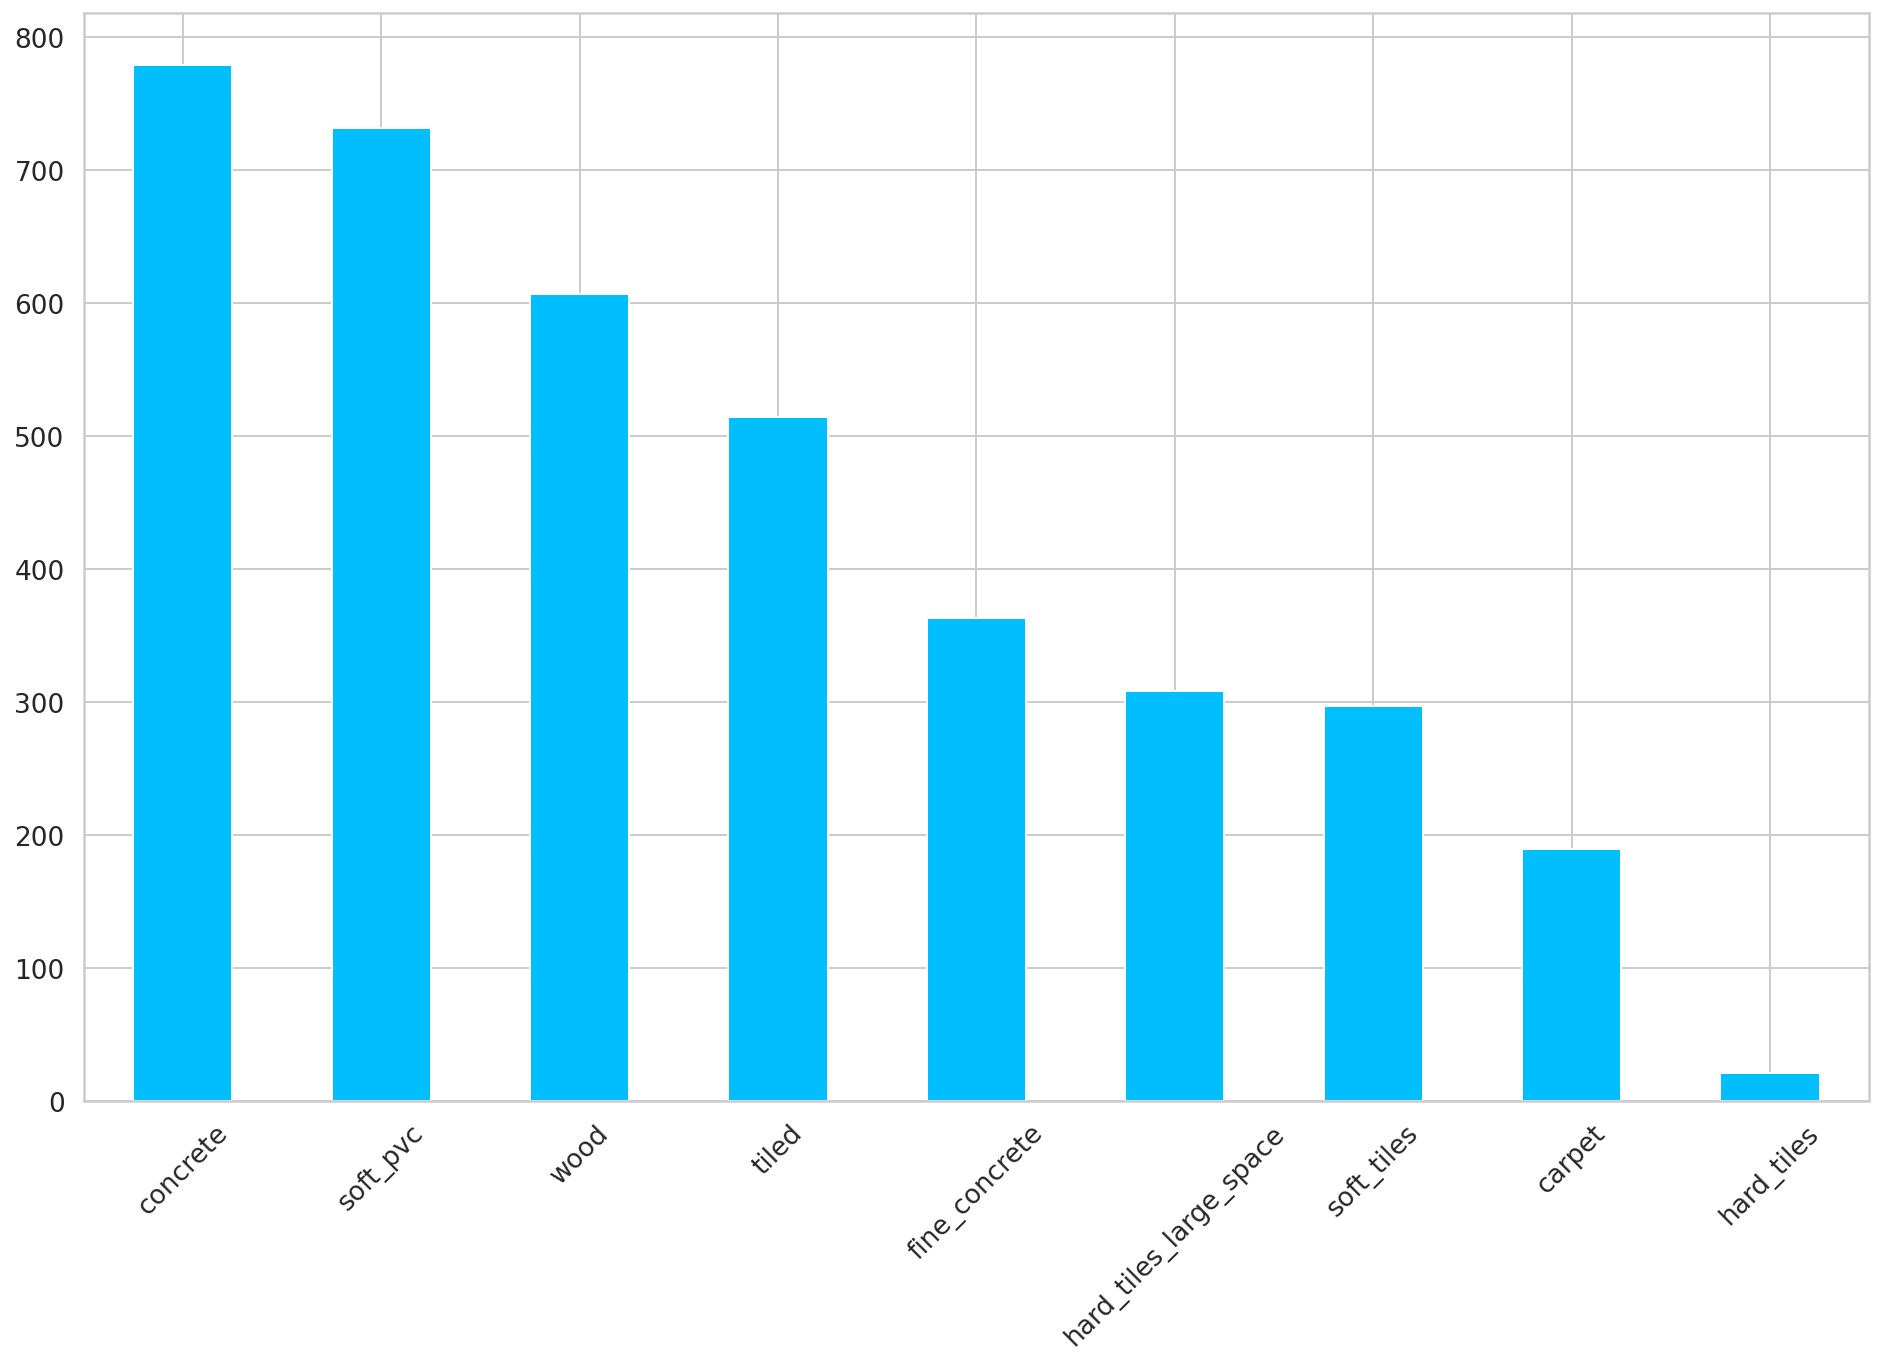

In [18]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show();

In [19]:
# resampling, balancing required

# PREPROCESSING

In [20]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [21]:
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [22]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [23]:
y_train['label'] = encoded_labels

In [24]:
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [25]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [26]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [27]:
X_train.series_id.value_counts()

0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: series_id, Length: 3810, dtype: int64

In [28]:
(X_train.series_id.value_counts() == 128).sum() == len(y_train)

True

In [29]:
sequences = []

In [30]:
for series_id, group in X_train.groupby('series_id'):
  sequence_features = group[FEATURE_COLUMNS]
  label = y_train[y_train.series_id == series_id].iloc[0].label
  
  sequences.append((sequence_features, label))

In [31]:
len(sequences)

3810

In [32]:
# Будут последовательности для crop
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

In [33]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, stratify=encoded_labels)

In [34]:
len(train_sequences), len(test_sequences)

(3048, 762)

In [35]:
train_sequences[0]

(        orientation_X  orientation_Y  orientation_Z  orientation_W  \
 385920       -0.96506        0.21613       0.025659       -0.14588   
 385921       -0.96511        0.21593       0.025611       -0.14587   
 385922       -0.96516        0.21573       0.025562       -0.14584   
 385923       -0.96521        0.21554       0.025509       -0.14582   
 385924       -0.96526        0.21533       0.025475       -0.14578   
 ...               ...            ...            ...            ...   
 386043       -0.96960        0.19493       0.022188       -0.14627   
 386044       -0.96962        0.19479       0.022178       -0.14631   
 386045       -0.96965        0.19461       0.022140       -0.14631   
 386046       -0.96969        0.19444       0.022093       -0.14631   
 386047       -0.96973        0.19426       0.022046       -0.14630   
 
         angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 385920            0.015542            0.078234            -0.16558   
 385

In [36]:
train_sequences[3047][0]

,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
65792,0.95129,-0.26897,-0.033822,0.14685,0.169720,-0.070292,0.12821,-2.68320,0.65861,-10.7140
65793,0.95127,-0.26895,-0.033746,0.14701,0.109230,0.095503,0.17015,-0.64143,4.34230,-6.5769
65794,0.95120,-0.26916,-0.033649,0.14710,-0.054006,0.067510,0.19089,-2.05410,5.91560,-4.9379
65795,0.95110,-0.26946,-0.033743,0.14716,-0.068806,-0.098065,0.24433,-0.59149,1.45540,-11.6450
65796,0.95103,-0.26979,-0.033775,0.14699,0.124280,-0.101020,0.25499,-1.82400,-2.18510,-15.8170
...,...,...,...,...,...,...,...,...,...,...
65915,0.94679,-0.28184,-0.033203,0.15183,-0.016142,-0.045110,0.14822,-0.56891,-1.24380,-8.4967
65916,0.94673,-0.28202,-0.033234,0.15189,-0.055826,-0.033413,0.14575,1.39640,-0.87660,-10.6260
65917,0.94672,-0.28215,-0.033067,0.15174,-0.023237,0.054000,0.14886,-0.54518,-3.66460,-12.5940
65918,0.94669,-0.28226,-0.032956,0.15173,0.038427,0.065888,0.10133,1.40980,-0.48055,-9.4663


In [37]:
train_sequences[3047][1]

7

# Dataset

In [38]:
class SurfaceDataset(Dataset):

  def __init__(self, sequences):
    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    sequence, label = self.sequences[idx]
    return dict(
	    sequence=torch.Tensor(sequence.to_numpy()),
	    label=torch.tensor(label).long()
	  )

In [39]:
class SurfaceDataModule(pl.LightningDataModule):

	def __init__(self, train_sequences, test_sequences, batch_size):
		super().__init__()
		self.train_sequences = train_sequences
		self.test_sequences = test_sequences
		self.batch_size = batch_size

	def setup(self, stage=None):
		self.train_dataset = SurfaceDataset(self.train_sequences)
		self.test_dataset = SurfaceDataset(self.test_sequences)

	def train_dataloader(self):
		return DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			shuffle=True,
			num_workers=cpu_count()
		)

	def val_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			shuffle=False,
			num_workers=cpu_count()
		)

	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			shuffle=False,
			num_workers=cpu_count()
		)

In [40]:
#N_EPOCHS = 250
N_EPOCHS = 200
#N_EPOCHS = 25
#BATCH_SIZE = 64
BATCH_SIZE = 128

In [41]:
data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

# Model

In [42]:
class SequenceModel(nn.Module):

	def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
		super().__init__()
		self.n_hidden = n_hidden

		self.lstm = nn.LSTM(
			input_size=n_features,
			hidden_size=n_hidden,
			num_layers=n_layers,
			#batch_size=True,
			batch_first=True,
			dropout=0.75
		)
	
		self.classifier = nn.Linear(n_hidden, n_classes)
	
	def forward(self, x):
		#print('x_shape:',x.shape)
		self.lstm.flatten_parameters()
		_, (hidden, _) = self.lstm(x)
	  
		out = hidden[-1]
		return self.classifier(out)

In [43]:
class SurfacePredictor(pl.LightningModule):
	def __init__(self, n_features: int, n_classes: int):
		super().__init__()
		self.model = SequenceModel(n_features, n_classes)
		self.criterion = nn.CrossEntropyLoss()
	
	def forward(self, x, labels=None):
		output = self.model(x)
		loss = 0
		if labels is not None:
			loss = self.criterion(output, labels)
		return loss, output
	
	def training_step(self, batch, batch_idx):
		#print('batch.keys():', batch.keys())
		sequences = batch['sequence']
		labels = batch['label']
		loss, outputs = self(sequences, labels)
		predictions = torch.argmax(outputs, dim=1)
		step_accuracy = accuracy(predictions, labels)
		
		self.log('train_loss', loss, prog_bar=True, logger=True)
		self.log('train_accuracy', step_accuracy, prog_bar=True, logger=True)
		return {'loss': loss, 'accuracy': step_accuracy}
		
	def validation_step(self, batch, batch_idx):
		#print('batch.keys():', batch.keys())
		sequences = batch['sequence']
		labels = batch['label']
		loss, outputs = self(sequences, labels)
		predictions = torch.argmax(outputs, dim=1)
		step_accuracy = accuracy(predictions, labels)
		
		self.log('val_loss', loss, prog_bar=True, logger=True)
		self.log('val_accuracy', step_accuracy, prog_bar=True, logger=True)
		return {'loss': loss, 'accuracy': step_accuracy}
	
	def test_step(self, batch, batch_idx):
		#print('batch.keys():', batch.keys())
		sequences = batch['sequence']
		labels = batch['label']
		loss, outputs = self(sequences, labels)
		predictions = torch.argmax(outputs, dim=1)
		step_accuracy = accuracy(predictions, labels)
		
		self.log('test_loss', loss, prog_bar=True, logger=True)
		self.log('test_accuracy', step_accuracy, prog_bar=True, logger=True)
		return {'loss': loss, 'accuracy': step_accuracy}
	
	def configure_optimizers(self):
		return optim.Adam(self.parameters(), lr=0.0001)

In [44]:
#print(len(FEATURE_COLUMNS))

In [45]:
model = SurfacePredictor(
		n_features=len(FEATURE_COLUMNS),
		n_classes=len(label_encoder.classes_)
)
print(model)

SurfacePredictor(
  (model): SequenceModel(
    (lstm): LSTM(10, 256, num_layers=3, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=9, bias=True)
  )
  (criterion): CrossEntropyLoss()
)


In [46]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working

In [47]:
checkpoint_callback = ModelCheckpoint(
	dirpath='checkpoints',
	filename='best-checkpoint',
	save_top_k=1,
	verbose=True,
	monitor='val_loss',
	#monitor='test_loss',
	mode='min'
)
#checkpoint_callback

In [48]:
logger = TensorBoardLogger('lightning_logs', name='surface')
#logger = TensorBoardLogger('logs', name='surface')

In [49]:
trainer = pl.Trainer(
	logger=logger,
	#checkpoint_callback=checkpoint_callback,
	#callbacks=checkpoint_callback,
	callbacks=[checkpoint_callback],
	max_epochs=N_EPOCHS,
	#gpus=1,
    accelerator='gpu',
    devices=1,
	#progress_bar_refresh_rate=30
)

In [50]:
#trainer2 = pl.Trainer(
	#logger=logger,
#	callbacks=[checkpoint_callback],
#	max_epochs=N_EPOCHS,
	#gpus=1,
#    accelerator='gpu',
#    devices=1,
	#progress_bar_refresh_rate=30
#)

In [51]:
#!ls /kaggle/working/*

/kaggle/working/X_test.csv
/kaggle/working/X_train.csv
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/career-con-2019.zip
/kaggle/working/sample_submission.csv
/kaggle/working/y_train.csv


In [52]:
trainer.fit(model, data_module)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [53]:
# last epochs no improvement from around #190

In [54]:
trainer.test(dataloaders=data_module.train_dataloader())

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8710629940032959     │
│         test_loss         │    0.37505418062210083    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.37505418062210083, 'test_accuracy': 0.8710629940032959}]

In [55]:
trainer.test(dataloaders=data_module.val_dataloader())

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7755905389785767     │
│         test_loss         │    0.6542063355445862     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6542063355445862, 'test_accuracy': 0.7755905389785767}]

In [56]:
#trainer.test()
trainer.test(dataloaders=data_module.test_dataloader())
#trainer.test(dataloaders=test_dataloader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7755905389785767     │
│         test_loss         │    0.6542063355445862     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6542063355445862, 'test_accuracy': 0.7755905389785767}]

In [57]:
# 0.79 accuracy; 0.59 loss

# Predictions

In [87]:
trainer.checkpoint_callback.best_model_path

'/kaggle/working/checkpoints/best-checkpoint.ckpt'

In [86]:
trainer.predicted_ckpt_path # .predict(dataloaders=data_module.test_dataloader())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightningDeprecationWarning: The `Trainer.predicted_ckpt_path` attribute was deprecated in v1.6 and will be removed in v1.8. The path of a checkpoint loaded via `Trainer.{fit,validate,test,predict}` should be accessed via `Trainer.ckpt_path` instead.
  """Entry point for launching an IPython kernel.


'/kaggle/working/checkpoints/best-checkpoint.ckpt'

In [59]:
# @link https://stackoverflow.com/questions/72732177/isadirectoryerror-when-loading-my-pytorch-model-with-load-from-checkpoint
# model=GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [60]:
# @link https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html
'''
# call after training
trainer = Trainer()
trainer.fit(model)

# automatically auto-loads the best weights from the previous run
trainer.test(dataloaders=test_dataloader)

# or call with pretrained model
model = MyLightningModule.load_from_checkpoint(PATH)
trainer = Trainer()
trainer.test(model, dataloaders=test_dataloader)
'''

'\n# call after training\ntrainer = Trainer()\ntrainer.fit(model)\n\n# automatically auto-loads the best weights from the previous run\ntrainer.test(dataloaders=test_dataloader)\n\n# or call with pretrained model\nmodel = MyLightningModule.load_from_checkpoint(PATH)\ntrainer = Trainer()\ntrainer.test(model, dataloaders=test_dataloader)\n'

In [61]:
# Так не работало
'''
trained_model =SurfacePredictor(
	callbacks=[trainer.checkpoint_callback.best_model_path],
    #trainer.checkpoint_callback.best_model_path,
	n_features=len(FEATURE_COLUMNS),
	n_classes=len(label_encoder.classes_)
)
'''

'\ntrained_model =SurfacePredictor(\n\tcallbacks=[trainer.checkpoint_callback.best_model_path],\n    #trainer.checkpoint_callback.best_model_path,\n\tn_features=len(FEATURE_COLUMNS),\n\tn_classes=len(label_encoder.classes_)\n)\n'

In [62]:
# Так вроде заработало
trained_model = SurfacePredictor(
	n_features=len(FEATURE_COLUMNS),
	n_classes=len(label_encoder.classes_)
)#.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
trained_model.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)
#trainer = Trainer()
#trainer.test(model_sandbox, dataloaders=test_dataloader)

SurfacePredictor(
  (model): SequenceModel(
    (lstm): LSTM(10, 256, num_layers=3, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=9, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

In [170]:
predictions = trainer.test(dataloaders=data_module.test_dataloader())
print(predictions)

#print(trainer.predict(dataloaders=data_module.test_dataloader()))

#trainer.predicted_ckpt_path

#predictions = trainer.test(model=self.model, datamodule=self.data_module)
#print(predictions)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7755905389785767     │
│         test_loss         │    0.6542063355445862     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6542063355445862, 'test_accuracy': 0.7755905389785767}]


In [160]:
#predictions = trainer.predict(trained_model, ckpt_path='best', dataloaders=data_module.test_dataloader(), return_predictions=True)
predictions = trainer.predict(ckpt_path='best', dataloaders=data_module.test_dataloader())

Predicting: 24it [00:00, ?it/s]

AttributeError: 'dict' object has no attribute 'dim'

In [ ]:
predictions

In [63]:
trained_model.freeze()

In [119]:
trained_model = SurfacePredictor(
	n_features=len(FEATURE_COLUMNS),
	n_classes=len(label_encoder.classes_)
)
trained_model.load_from_checkpoint(
    #trainer.predicted_ckpt_path,
    trainer.ckpt_path,
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)

SurfacePredictor(
  (model): SequenceModel(
    (lstm): LSTM(10, 256, num_layers=3, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=9, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

In [120]:
test_dataset = SurfaceDataset(test_sequences)

In [121]:
predictions = []
labels = []

In [122]:
for item in tqdm(test_dataset):
	sequence = item['sequence']
	label = item['label']
	
	_, output = trained_model(sequence.unsqueeze(dim=0))
	prediction = torch.argmax(output, dim=1)
	predictions.append(prediction.item())
	labels.append(label.item())

  0%|          | 0/762 [00:00<?, ?it/s]

In [123]:
print(
    classification_report(labels, predictions, target_names=label_encoder.classes_, zero_division=True)
)

                        precision    recall  f1-score   support

                carpet       0.05      0.61      0.08        38
              concrete       1.00      0.00      0.00       156
         fine_concrete       1.00      0.00      0.00        73
            hard_tiles       1.00      0.00      0.00         4
hard_tiles_large_space       0.00      0.00      0.00        62
              soft_pvc       0.20      0.32      0.25       146
            soft_tiles       0.15      0.05      0.08        59
                 tiled       1.00      0.00      0.00       103
                  wood       1.00      0.00      0.00       121

              accuracy                           0.09       762
             macro avg       0.60      0.11      0.05       762
          weighted avg       0.65      0.09      0.06       762



In [124]:
def show_confusion_matrix(confusion_matrix):
	hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
	hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
	hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
	plt.ylabel('True surface')
	plt.xlabel('Prediction surface')

In [125]:
from sklearn.metrics import confusion_matrix
y_sandbox_true = [2, 0, 2, 2, 0, 1]
y_sandbox_pred = [0, 0, 2, 2, 0, 2]
sandbox_cm = confusion_matrix(y_sandbox_true, y_sandbox_pred)

df_sandbox_cm = pd.DataFrame(
    sandbox_cm#, index=label_encoder.classes_, columns=label_encoder.classes_
)
df_sandbox_cm

,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


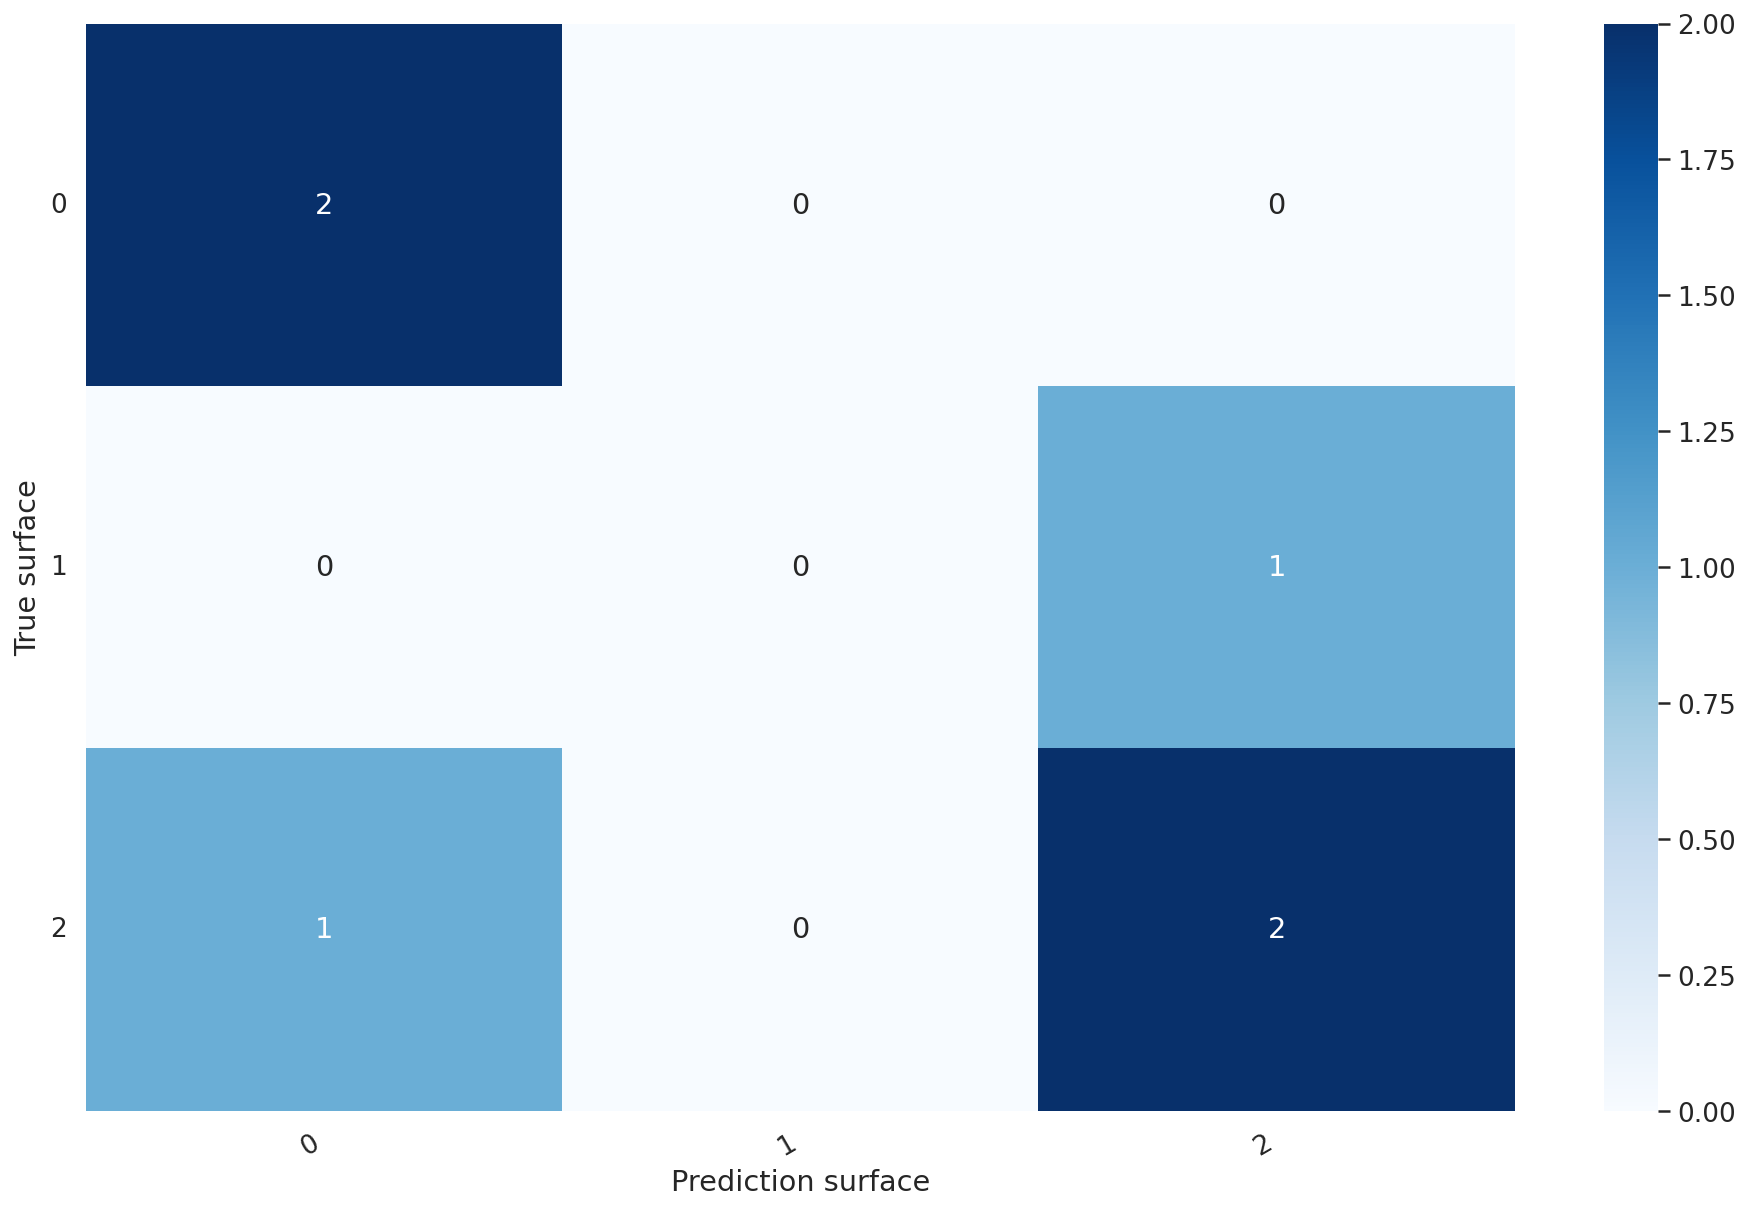

In [126]:
show_confusion_matrix(df_sandbox_cm)

In [127]:
labels[-10:]

[0, 8, 0, 2, 1, 1, 2, 1, 1, 5]

In [128]:
list(set(labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [129]:
predictions[-10:]

[0, 0, 0, 0, 0, 5, 0, 0, 0, 4]

In [130]:
list(set(predictions))

[0, 4, 5, 6]

In [131]:
len(labels), len(predictions)

(762, 762)

In [158]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index=label_encoder.classes_, columns=label_encoder.classes_
)
df_cm

,carpet,concrete,fine_concrete,hard_tiles,hard_tiles_large_space,soft_pvc,soft_tiles,tiled,wood
carpet,23,0,0,0,0,15,0,0,0
concrete,114,0,0,0,1,38,3,0,0
fine_concrete,47,0,0,0,1,24,1,0,0
hard_tiles,3,0,0,0,0,1,0,0,0
hard_tiles_large_space,43,0,0,0,0,17,2,0,0
soft_pvc,94,0,0,0,2,46,4,0,0
soft_tiles,37,0,0,0,2,17,3,0,0
tiled,70,0,0,0,0,31,2,0,0
wood,76,0,0,0,0,40,5,0,0


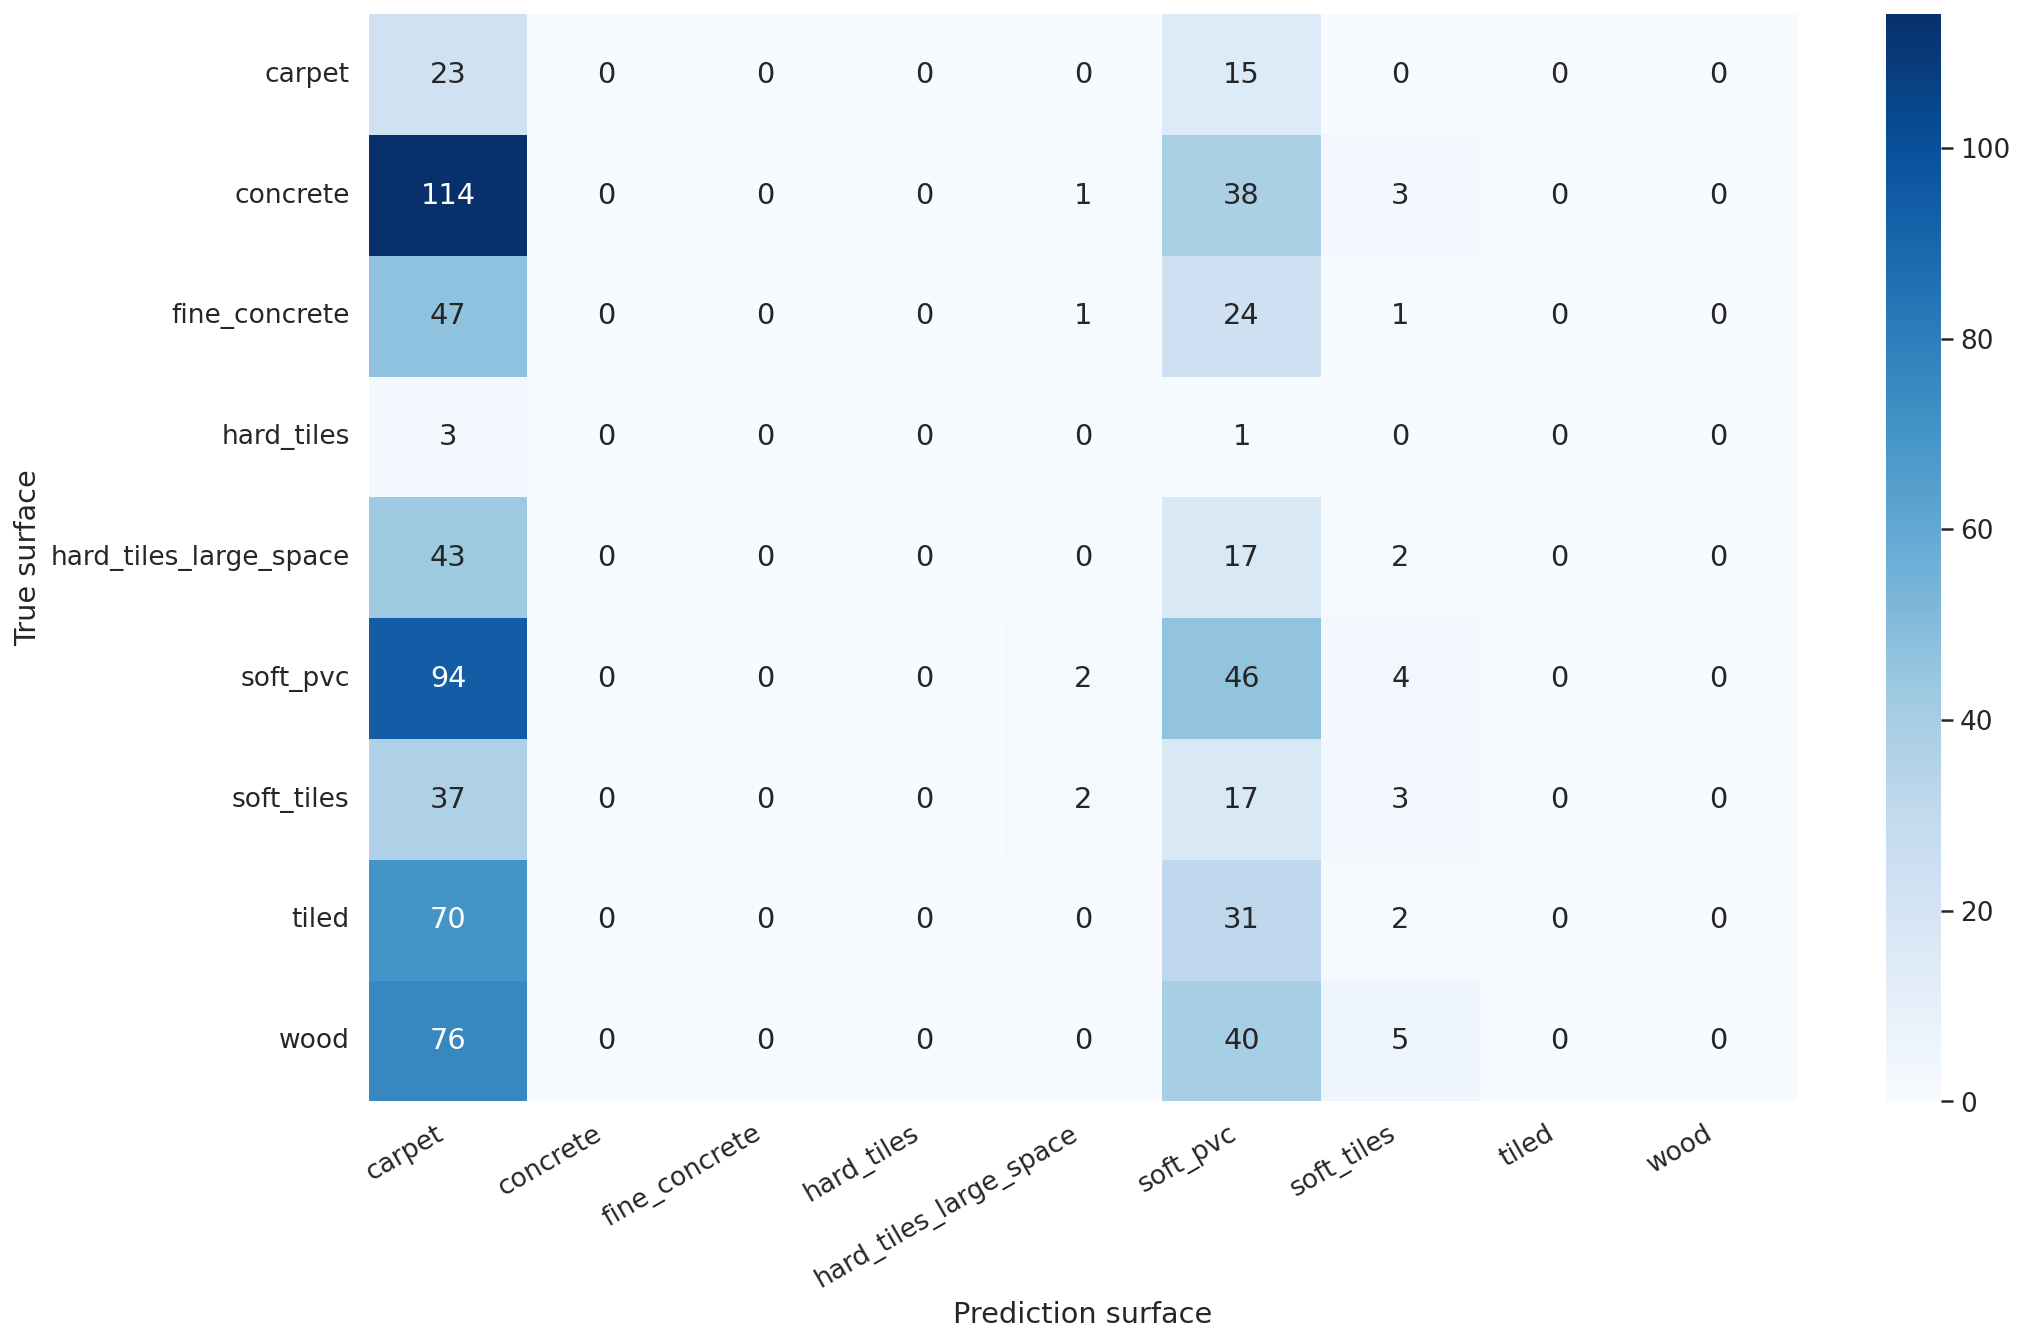

In [159]:
show_confusion_matrix(df_cm)